In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import argparse

import tensorflow as tf
from tensorflow.keras import layers, Model

import sklearn.metrics
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../'); sys.path.append('../..')
import utils

seed = 314159

2023-05-01 20:10:28.767483: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 20:10:28.909344: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-01 20:10:28.952345: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-01 20:10:29.585256: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import wandb
wandb.login()

import logging
logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)

wandb_project_name = 'dev_abstracter_sorting_generalization'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: awni00. Use `wandb login --relogin` to force relogin


In [4]:
def create_callbacks(monitor='loss'):
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True),
#         tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'),
        wandb.keras.WandbMetricsLogger(log_freq='epoch'),
        # wandb.keras.WandbModelCheckpoint(filepath='models/model_{epoch:02d}', monitor=monitor, mode='auto', save_freq='epoch')
#         wandb.keras.WandbCallback(
#             monitor=monitor, log_weights=log_weights, log_gradients=log_gradients, save_model=save_model, save_graph=True,
#             training_data=train_ds, validation_data=val_ds,
#             labels=class_names, predictions=64, compute_flops=True)
        ]
    return callbacks

from transformer_modules import TeacherForcingAccuracy
teacher_forcing_acc_metric = TeacherForcingAccuracy(ignore_class=None)
metrics = [teacher_forcing_acc_metric]


loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, ignore_class=None, name='sparse_categorical_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam()

fit_kwargs = {'epochs': 200, 'batch_size': 128}


2023-05-01 20:10:35.863285: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 20:10:36.542998: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22296 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:8b:00.0, compute capability: 8.6


## Dataset and Utils

In [5]:
# region evaluation code
def evaluate_seq2seq_model(model, source_test, target_test, labels_test, start_token, print_=False):
    
    n = len(source_test)
    output = np.zeros(shape=(n, (seqs_length+1)), dtype=int)
    output[:,0] = start_token
    for i in range(seqs_length):
        predictions = model((source_test, output[:, :-1]), training=False)
        predictions = predictions[:, i, :]
        predicted_id = tf.argmax(predictions, axis=-1)
        output[:,i+1] = predicted_id

    elementwise_acc = (np.mean(output[:,1:] == labels_test))
    acc_per_position = [np.mean(output[:, i+1] == labels_test[:, i]) for i in range(seqs_length)]
    seq_acc = np.mean(np.all(output[:,1:]==labels_test, axis=1))


    teacher_forcing_acc = teacher_forcing_acc_metric(labels_test, model([source_test, target_test]))
    teacher_forcing_acc_metric.reset_state()

    if print_:
        print('element-wise accuracy: %.2f%%' % (100*elementwise_acc))
        print('full sequence accuracy: %.2f%%' % (100*seq_acc))
        print('teacher-forcing accuracy:  %.2f%%' % (100*teacher_forcing_acc))


    return_dict = {
        'elementwise_accuracy': elementwise_acc, 'full_sequence_accuracy': seq_acc,
        'teacher_forcing_accuracy': teacher_forcing_acc, 'acc_by_position': acc_per_position
        }

    return return_dict

def log_to_wandb(model, evaluation_dict):
    acc_by_position_table = wandb.Table(
        data=[(i, acc) for i, acc in enumerate(evaluation_dict['acc_by_position'])], 
        columns=["position", "element-wise accuracy at position"])

    evaluation_dict['acc_by_position'] = wandb.plot.line(
        acc_by_position_table, "position", "element-wise accuracy at position",
        title="Element-wise Accuracy By Position")

    wandb.log(evaluation_dict)

## Task 1: Transformer

In [6]:
task1_data = np.load('object_sorting_datasets/product_structure_object_sort_dataset.npy', allow_pickle=True).item()

objects, seqs, sorted_seqs, object_seqs, target, labels, start_token = (task1_data['objects'], task1_data['seqs'], task1_data['sorted_seqs'], task1_data['object_seqs'], \
    task1_data['target'], task1_data['labels'], task1_data['start_token'])

test_size = 0.2
val_size = 0.1

seqs_train, seqs_test, sorted_seqs_train, sorted_seqs_test, object_seqs_train, object_seqs_test, target_train, target_test, labels_train, labels_test = train_test_split(
    seqs, sorted_seqs, object_seqs, target, labels, test_size=0.2, random_state=seed)
seqs_train, seqs_val, sorted_seqs_train, sorted_seqs_val, object_seqs_train, object_seqs_val, target_train, target_val, labels_train, labels_val = train_test_split(
    seqs_train, sorted_seqs_train, object_seqs_train, target_train, labels_train, test_size=val_size/(1-test_size), random_state=seed)

seqs_length = seqs.shape[1]

In [7]:
transformer_kwargs = dict(
    num_layers=4, num_heads=2, dff=64, 
    input_vocab='vector', target_vocab=seqs_length+1,
    output_dim=seqs_length, embedding_dim=64)

rel_abstracter_kwargs = dict(
    num_layers=2, num_heads=2, dff=64, 
    input_vocab='vector', target_vocab=seqs_length+1,
    output_dim=seqs_length, embedding_dim=64,
    rel_attention_activation='softmax'
    )


In [8]:
from seq2seq_abstracter_models import Transformer 
argsort_model = Transformer(**transformer_kwargs)

argsort_model.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
argsort_model((object_seqs_train[:32], target_train[:32]));

argsort_model.summary()

2023-05-01 20:10:40.273730: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-01 20:10:41.034772: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_embedder (TimeDistri  multiple                 832       
 buted)                                                          
                                                                 
 target_embedder (Embedding)  multiple                 704       
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  167168    
                                                       

In [9]:

train_size = 500 # len(seqs_train)
X_train = object_seqs_train[:train_size], target_train[:train_size]
y_train = labels_train[:train_size]

X_val = object_seqs_val, target_val
y_val = labels_val

# run = wandb.init(project=wandb_project_name, group='Transformer, Task 1')
history = argsort_model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=100, batch_size=512)#, callbacks=create_callbacks(), **fit_kwargs)

Epoch 1/100
1/1 [==============================] - 10s 10s/step - loss: 3.1116 - teacher_forcing_accuracy: 0.0992 - val_loss: 3.3327 - val_teacher_forcing_accuracy: 0.1000
Epoch 2/100
1/1 [==============================] - 0s 264ms/step - loss: 3.2319 - teacher_forcing_accuracy: 0.1024 - val_loss: 2.6678 - val_teacher_forcing_accuracy: 0.1006
Epoch 3/100
1/1 [==============================] - 0s 256ms/step - loss: 2.6976 - teacher_forcing_accuracy: 0.1026 - val_loss: 2.5429 - val_teacher_forcing_accuracy: 0.1040
Epoch 4/100
1/1 [==============================] - 0s 257ms/step - loss: 2.5882 - teacher_forcing_accuracy: 0.0996 - val_loss: 2.4219 - val_teacher_forcing_accuracy: 0.1057
Epoch 5/100
1/1 [==============================] - 0s 256ms/step - loss: 2.4801 - teacher_forcing_accuracy: 0.0982 - val_loss: 2.3654 - val_teacher_forcing_accuracy: 0.1059
Epoch 6/100
1/1 [==============================] - 0s 255ms/step - loss: 2.4208 - teacher_forcing_accuracy: 0.0976 - val_loss: 2.3506 - 

In [52]:
simpleabstractor_kwargs = dict(
    embedding_dim=64, 
    input_vocab='vector', target_vocab=seqs_length+1, output_dim=seqs_length,
    abstractor_kwargs=dict(num_layers=1, num_heads=4, dff=64,
        use_pos_embedding=False, mha_activation_type='softmax'),
    decoder_kwargs=dict(num_layers=1, num_heads=4, dff=64, dropout_rate=0.1))

from seq2seq_abstracter_models import AutoregressiveSimpleAbstractor 
argsort_model = AutoregressiveSimpleAbstractor(**simpleabstractor_kwargs)

argsort_model.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
argsort_model((object_seqs_train[:32], target_train[:32]));

argsort_model.summary()

Model: "autoregressive_simple_abstractor_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_embedder (TimeDistri  multiple                 832       
 buted)                                                          
                                                                 
 target_embedder (Embedding)  multiple                 704       
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 relational_abstracter (Simp  multiple                 75584     
 leAbstractor)                  

In [53]:
# this was run with a relational abstractor 

train_size = 500 # len(seqs_train)
X_train = object_seqs_train[:train_size], target_train[:train_size]
y_train = labels_train[:train_size]

X_val = object_seqs_val, target_val
y_val = labels_val

# run = wandb.init(project=wandb_project_name, group='Transformer, Task 1')
history = argsort_model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=400, batch_size=512)#, callbacks=create_callbacks(), **fit_kwargs)

Epoch 1/400
1/1 [==============================] - 3s 3s/step - loss: 2.9113 - teacher_forcing_accuracy: 0.4653 - val_loss: 2.5405 - val_teacher_forcing_accuracy: 0.1057
Epoch 2/400
1/1 [==============================] - 0s 124ms/step - loss: 2.6133 - teacher_forcing_accuracy: 0.1088 - val_loss: 2.4708 - val_teacher_forcing_accuracy: 0.1051
Epoch 3/400
1/1 [==============================] - 0s 127ms/step - loss: 2.5484 - teacher_forcing_accuracy: 0.1052 - val_loss: 2.4598 - val_teacher_forcing_accuracy: 0.1096
Epoch 4/400
1/1 [==============================] - 0s 131ms/step - loss: 2.5276 - teacher_forcing_accuracy: 0.1050 - val_loss: 2.4234 - val_teacher_forcing_accuracy: 0.1075
Epoch 5/400
1/1 [==============================] - 0s 131ms/step - loss: 2.4803 - teacher_forcing_accuracy: 0.1078 - val_loss: 2.3837 - val_teacher_forcing_accuracy: 0.1096
Epoch 6/400
1/1 [==============================] - 0s 134ms/step - loss: 2.4473 - teacher_forcing_accuracy: 0.1052 - val_loss: 2.3523 - va

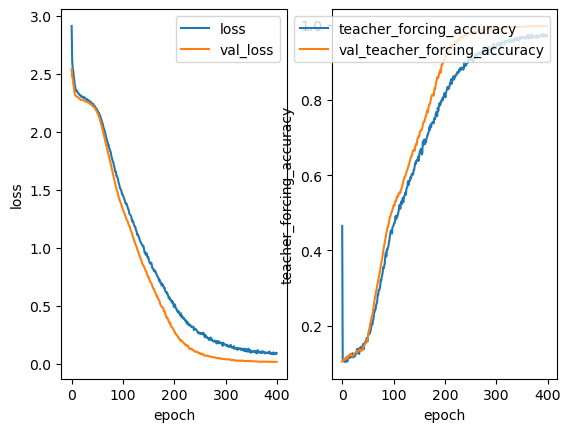

In [54]:
utils.plot_history(history, ('loss', 'teacher_forcing_accuracy'));

In [55]:
eval_dict = evaluate_seq2seq_model(argsort_model, object_seqs_train, target_train, labels_train, 
    start_token=start_token, print_=True)

element-wise accuracy: 98.15%
full sequence accuracy: 95.87%
teacher-forcing accuracy:  99.58%


In [56]:
eval_dict = evaluate_seq2seq_model(argsort_model, object_seqs_test, target_test, labels_test, 
    start_token=start_token, print_=True)
# log_to_wandb(argsort_model, eval_dict)
# wandb.finish(quiet=True)

element-wise accuracy: 98.31%
full sequence accuracy: 96.14%
teacher-forcing accuracy:  99.60%


In [27]:
from seq2seq_abstracter_models import Seq2SeqRelationalAbstracter 
argsort_model = Seq2SeqRelationalAbstracter(**rel_abstracter_kwargs)

argsort_model.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
argsort_model((object_seqs_train[:32], target_train[:32]));

argsort_model.summary()

Model: "seq2seq_relational_abstracter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_embedder (TimeDistri  multiple                 832       
 buted)                                                          
                                                                 
 target_embedder (Embedding)  multiple                 704       
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  83584     
                                     

In [22]:
# this was run with a relational abstractor 

train_size = 500 # len(seqs_train)
X_train = object_seqs_train[:train_size], target_train[:train_size]
y_train = labels_train[:train_size]

X_val = object_seqs_val, target_val
y_val = labels_val

# run = wandb.init(project=wandb_project_name, group='Transformer, Task 1')
history = argsort_model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=100, batch_size=128)#, callbacks=create_callbacks(), **fit_kwargs)

Epoch 1/100
4/4 [==============================] - 11s 1s/step - loss: 2.6281 - teacher_forcing_accuracy: 0.1086 - val_loss: 2.4001 - val_teacher_forcing_accuracy: 0.0982
Epoch 2/100
4/4 [==============================] - 1s 433ms/step - loss: 2.4097 - teacher_forcing_accuracy: 0.1142 - val_loss: 2.3132 - val_teacher_forcing_accuracy: 0.1133
Epoch 3/100
4/4 [==============================] - 1s 430ms/step - loss: 2.3481 - teacher_forcing_accuracy: 0.1002 - val_loss: 2.3063 - val_teacher_forcing_accuracy: 0.1125
Epoch 4/100
4/4 [==============================] - 1s 430ms/step - loss: 2.3376 - teacher_forcing_accuracy: 0.1082 - val_loss: 2.2981 - val_teacher_forcing_accuracy: 0.1138
Epoch 5/100
4/4 [==============================] - 1s 432ms/step - loss: 2.3099 - teacher_forcing_accuracy: 0.1148 - val_loss: 2.2920 - val_teacher_forcing_accuracy: 0.1151
Epoch 6/100
4/4 [==============================] - 1s 436ms/step - loss: 2.3069 - teacher_forcing_accuracy: 0.1218 - val_loss: 2.2866 - v

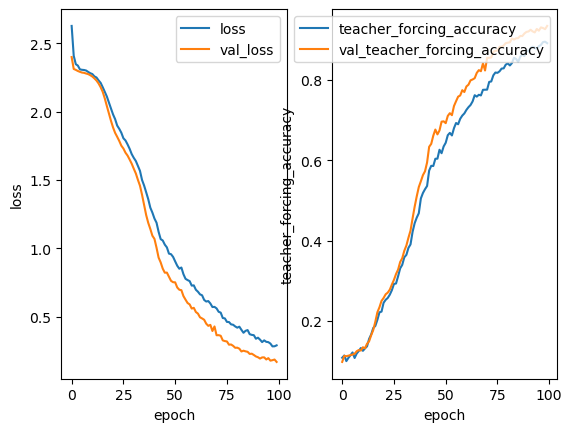

In [23]:
utils.plot_history(history, ('loss', 'teacher_forcing_accuracy'));

In [24]:
eval_dict = evaluate_seq2seq_model(argsort_model, object_seqs_train, target_train, labels_train, 
    start_token=start_token, print_=True)

2023-04-28 16:02:11.411063: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 170.90MiB (rounded to 179200000)requested by op MatMul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-28 16:02:11.425919: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2023-04-28 16:02:11.425989: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 225, Chunks in use: 223. 56.2KiB allocated for chunks. 55.8KiB in use in bin. 41.6KiB client-requested in use in bin.
2023-04-28 16:02:11.426014: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (512): 	Total Chunks: 91, Chunks in use: 90. 48.0KiB allocated for chunks. 47.5KiB in use in bin. 45.0KiB client-requested in use in bin.
2023-04-28 16:02:11.426040:

ResourceExhaustedError: Exception encountered when calling layer "dense_75" "                 f"(type Dense).

{{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[700000,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:MatMul]

Call arguments received by layer "dense_75" "                 f"(type Dense):
  • inputs=tf.Tensor(shape=(700000, 8), dtype=float32)

In [25]:
eval_dict = evaluate_seq2seq_model(argsort_model, object_seqs_test, target_test, labels_test, 
    start_token=start_token, print_=True)
# log_to_wandb(argsort_model, eval_dict)
# wandb.finish(quiet=True)

2023-04-28 16:02:21.805292: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 48.83MiB (rounded to 51200000)requested by op MatMul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-28 16:02:21.805353: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2023-04-28 16:02:21.805365: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 225, Chunks in use: 223. 56.2KiB allocated for chunks. 55.8KiB in use in bin. 41.6KiB client-requested in use in bin.
2023-04-28 16:02:21.805375: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (512): 	Total Chunks: 91, Chunks in use: 90. 48.0KiB allocated for chunks. 47.5KiB in use in bin. 45.0KiB client-requested in use in bin.
2023-04-28 16:02:21.805385: I

ResourceExhaustedError: Exception encountered when calling layer "dense_75" "                 f"(type Dense).

{{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[200000,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:MatMul]

Call arguments received by layer "dense_75" "                 f"(type Dense):
  • inputs=tf.Tensor(shape=(200000, 8), dtype=float32)

## Task 1: Seq2Seq Relational Abstracter

In [12]:
task1_data = np.load('object_sorting_datasets/task1_object_sort_dataset.npy', allow_pickle=True).item()

objects, seqs, sorted_seqs, object_seqs, target, labels, start_token = (task1_data['objects'], task1_data['seqs'], task1_data['sorted_seqs'], task1_data['object_seqs'], \
    task1_data['target'], task1_data['labels'], task1_data['start_token'])

test_size = 0.2
val_size = 0.1

seqs_train, seqs_test, sorted_seqs_train, sorted_seqs_test, object_seqs_train, object_seqs_test, target_train, target_test, labels_train, labels_test = train_test_split(
    seqs, sorted_seqs, object_seqs, target, labels, test_size=0.2, random_state=seed)
seqs_train, seqs_val, sorted_seqs_train, sorted_seqs_val, object_seqs_train, object_seqs_val, target_train, target_val, labels_train, labels_val = train_test_split(
    seqs_train, sorted_seqs_train, object_seqs_train, target_train, labels_train, test_size=val_size/(1-test_size), random_state=seed)

seqs_length = seqs.shape[1]

In [13]:
from seq2seq_abstracter_models import Seq2SeqRelationalAbstracter
argsort_model = Seq2SeqRelationalAbstracter(
    num_layers=2, num_heads=2, dff=64, 
    input_vocab='vector', target_vocab=seqs_length+1, output_dim=seqs_length,
    embedding_dim=64)

argsort_model.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
argsort_model((object_seqs_train[:32], target_train[:32]));

argsort_model.summary()

Model: "seq2seq_relational_abstracter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_embedder (TimeDistri  multiple                 576       
 buted)                                                          
                                                                 
 target_embedder (Embedding)  multiple                 704       
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  83584     
                                     

In [14]:
train_size = 1000 # len(seqs_train)
X_train = object_seqs_train[:train_size], target_train[:train_size]
y_train = labels_train[:train_size]

X_val = object_seqs_val, target_val
y_val = labels_val

# run = wandb.init(project=wandb_project_name, group='Transformer, Task 1')
history = argsort_model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=100, batch_size=128)#, callbacks=create_callbacks(), **fit_kwargs)

Epoch 1/100
8/8 [==============================] - 7s 270ms/step - loss: 2.5176 - teacher_forcing_accuracy: 0.0981 - val_loss: 2.3176 - val_teacher_forcing_accuracy: 0.1101
Epoch 2/100
8/8 [==============================] - 1s 130ms/step - loss: 2.3316 - teacher_forcing_accuracy: 0.1112 - val_loss: 2.2954 - val_teacher_forcing_accuracy: 0.1208
Epoch 3/100
8/8 [==============================] - 1s 130ms/step - loss: 2.3153 - teacher_forcing_accuracy: 0.1130 - val_loss: 2.2878 - val_teacher_forcing_accuracy: 0.1156
Epoch 4/100
8/8 [==============================] - 1s 129ms/step - loss: 2.3085 - teacher_forcing_accuracy: 0.1118 - val_loss: 2.2774 - val_teacher_forcing_accuracy: 0.1260
Epoch 5/100
8/8 [==============================] - 1s 130ms/step - loss: 2.2806 - teacher_forcing_accuracy: 0.1279 - val_loss: 2.2541 - val_teacher_forcing_accuracy: 0.1441
Epoch 6/100
8/8 [==============================] - 1s 131ms/step - loss: 2.2505 - teacher_forcing_accuracy: 0.1440 - val_loss: 2.2024 -

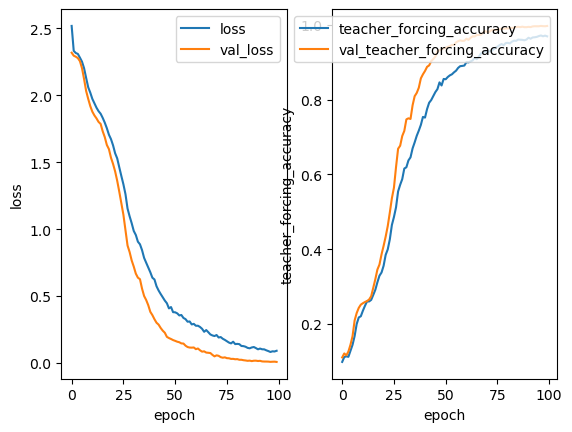

In [15]:
utils.plot_history(history, ('loss', 'teacher_forcing_accuracy'));

In [16]:
eval_dict = evaluate_seq2seq_model(argsort_model, object_seqs_train, target_train, labels_train, 
    start_token=start_token, print_=True)

element-wise accuracy: 99.44%
full sequence accuracy: 97.90%
teacher-forcing accuracy:  99.78%


In [17]:
eval_dict = evaluate_seq2seq_model(argsort_model, object_seqs_test, target_test, labels_test, 
    start_token=start_token, print_=True)
# log_to_wandb(argsort_model, eval_dict)
# wandb.finish(quiet=True)

element-wise accuracy: 99.45%
full sequence accuracy: 97.90%
teacher-forcing accuracy:  99.79%
